In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming,euclidean
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
import seaborn as sns
import datetime, nltk, warnings
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
#import the cleaned and engineered dataset 
df = pd.read_csv('ViettelCustSegment_final_2.csv')

In [3]:
#dropping some unnnecessary columns
df = df[['msisdn', 'sum_gdtc', 'count_gdtc', 'max_gdtc', 'recency',
       'hypothetical_trans_amount', 'usage_length_in_days',
       'error_per_day', 'error_req_percentage', 'last_code=error',
       'last_error_sodu', 'last_error_mapin', 'last_error_cachdung',
       'tt_diennuoc', 'tt_taichinh', 'tt_muasam', 'tt_vienthong', 'gender',
       'pin_lock', 'pin_ok','card_status']]
#Columns using categorical values: 8 : 19

In [4]:
#Scaling the dataset for clustering and check each features contribution to total variance
X = df.iloc[:,1:].values
print(X.shape)

scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

(758157, 20)


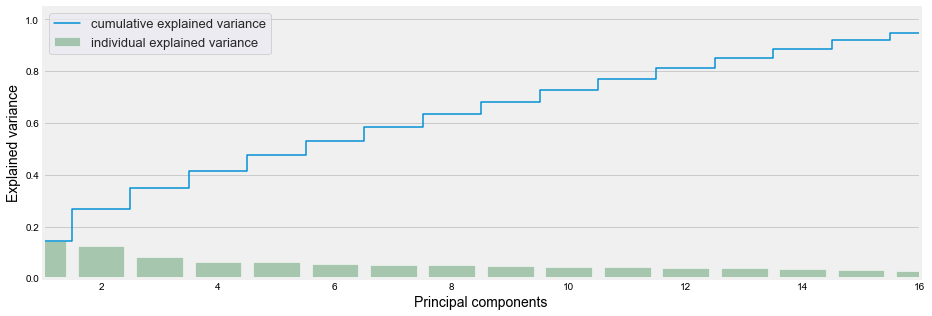

In [5]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_X)
pca_samples = pca.transform(scaled_X)


fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(scaled_X.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,scaled_X.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 15)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

For this clustering task, the algorithm of choice will be K-Prototype due to its robustness to both numerical and categorical features. Instead of using Euclidean distance like K-Means or using Hamming distance like K-Modes, it combines the cost function as defined in my_silhoutte() function

The criterion for ideal number of cluster is 
- no cluster has too few datapoints
- high average silhoutte score. (instead of WCSS) 

In [6]:
def my_silhoutte(data,cluster,numcat_split_idx,num_cluster):
    '''Self written function to calculate silhoutte score given a dataset and its cluster
    ---------------------------------------------------------------
    - data: array
    - cluster: array
    - numcat_split_idx: the dataset shall be organized in a manner that all numerical features will be adjacent to one another
    and all categorical features will be adjacent to one another. The index splitting between 2 types is then numcat_split_idx
    -num_cluster: number of clusters in the dataset'''
    gamma = 0.5 * data[:,:numcat_split_idx].std() #gamma = 0.5 * standard deviation of numeric features. For more information refer to Huang(97)
    silhoutte = []
    for i in range(len(data)):
        dist_a = euclidean(data[i,:numcat_split_idx],kproto.cluster_centroids_[0][clusters[i]]) + gamma * hamming(data[i][numcat_split_idx:data.shape[1]],kproto.cluster_centroids_[1][clusters[i]])
        dist_b_list = []
        for v in range(num_cluster):
            if v != cluster[i]:
                dist_b_temp = euclidean(data[i,:numcat_split_idx],kproto.cluster_centroids_[0][v]) + gamma * hamming(data[0][numcat_split_idx:data.shape[1]],kproto.cluster_centroids_[1][v])
                dist_b_list.append(dist_b_temp)
        dist_b = min(dist_b_list)
        silhoutte.append((dist_b - dist_a) / max(dist_a,dist_b))
    
    
    
    return silhoutte

In [17]:
clusters_list = []
silhoutte_list = []
numcat_split_idx = 8
gamma = 0.5 * scaled_X[:,:numcat_split_idx].std() 

for i in range(8,9): 
    kproto = KPrototypes(n_clusters=i, max_iter= 500, init='Huang', verbose=2,n_init = 5)
    clusters = kproto.fit_predict(scaled_X, categorical=[8,9,10,11,12,13,14,15,16,17,18,19])
    print(i)
    clusters_list.append(clusters)
    silhoutte = my_silhoutte(scaled_X,clusters,numcat_split_idx=numcat_split_idx,num_cluster=i)
    silhoutte_list.append(silhoutte)

pd.DataFrame(clusters_list).to_csv(r"C:\Users\os_sonnh1\Downloads\pythonscript\REALWORK\KPro_params\real_cl_list.csv")
pd.DataFrame(silhoutte_list).to_csv(r"C:\Users\os_sonnh1\Downloads\pythonscript\REALWORK\KPro_params\real_silhoutte_list.csv")
    
#chua tính silhoutte cho n_cluster = 5    

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/500, moves: 337369, ncost: 3282396.6281130225
Run: 1, iteration: 2/500, moves: 82080, ncost: 3104117.1342722294
Run: 1, iteration: 3/500, moves: 52672, ncost: 3095840.4787491853
Run: 1, iteration: 4/500, moves: 24687, ncost: 3089918.863494921
Run: 1, iteration: 5/500, moves: 13754, ncost: 3072666.1296452787
Run: 1, iteration: 6/500, moves: 13958, ncost: 3061322.3752771327
Run: 1, iteration: 7/500, moves: 6369, ncost: 3058069.312113221
Run: 1, iteration: 8/500, moves: 5797, ncost: 3054104.5150141423
Run: 1, iteration: 9/500, moves: 8083, ncost: 3036249.10276828
Run: 1, iteration: 10/500, moves: 8967, ncost: 2957141.7267152807
Run: 1, iteration: 11/500, moves: 5244, ncost: 2867552.452682794
Run: 1, iteration: 12/500, moves: 2689, ncost: 2797402.7251371336
Run: 1, iteration: 13/500, moves: 1328, ncost: 2712651.372673473
Run: 1, iteration: 14/500, moves: 682, ncost: 2647399.166779778
Run: 1